In [28]:
import pandas as pd
from datetime import datetime,timedelta
import requests
import json
from vnpy.trader.app.ctaStrategy import BacktestingEngine

# 创建回测引擎对象
engine = BacktestingEngine()

# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase('VnTrader_1Min_Db')  # 设置使用的历史数据库
engine.setStartDate('20180601 12:00',initHours=200) # 设置回测用的数据起始日期
engine.setEndDate('20181129 12:00') # 设置回测用的数据终止日期

# 配置回测引擎参数
engine.setSlippage(0.002)    # 设置滑点
engine.setRate(5/10000)   # 设置手续费千1
engine.setCapital(100000)  # 设置回测本金



In [105]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta

########################################################################
# 策略继承CtaTemplate
class LinearStrategy(CtaTemplate):
    """LinearStrategy"""
    className = 'LinearStrategy'
    author = 'yuanhongjian'
    
    # 策略参数（与参数列表对应）
     # 参数设置
    regPeriod = 40
    residualSmaPeriod = 12; residualLmaPeriod = 24
    lowVolThrehold = 0.005; highVolThrehold = 0.05
    BBandPeriod = 20
    
    lot = 1          # 设置手数
    
    # 策略变量（与变量列表对应）
    transactionPrice = {} # 记录成交价格
    
    # 参数列表
    paramList = ['regPeriod','lowVolThrehold', 'highVolThrehold','BBandPeriod','residualSmaPeriod','residualLmaPeriod']    
    
    # 变量列表
    varList = ['transactionPrice']  
    
    # 同步列表，保存了需要保存到数据库的变量名称（一般不修改）
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super().__init__(ctaEngine, setting)
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典（对应上面的策略变量）
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
   
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
        
    #----------------------------------------------------------------------
    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.stopRatio)
        longProfit = self.transactionPrice[symbol]*(1+4*self.stopRatio)
        shortStop = self.transactionPrice[symbol]*(1+self.stopRatio)
        shortProfit = self.transactionPrice[symbol]*(1-4*self.stopRatio)
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.posDict[symbol+'_LONG'])

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.posDict[symbol+'_SHORT'])

    def on60MinBar(self, bar):
        """收到60分钟Bar推送"""
        symbol = bar.vtSymbol
        
        am = self.getArrayManager(symbol, "60m") # 获取历史数组
        
        if not am.inited:
            return
        
        # 计算策略需要的信号-------------------------------------------------
       

        # 指标计算
        prediction = ta.LINEARREG(am.close, self.regPeriod)
        residual = (am.close - prediction) / am.close
        residualSma = ta.MA(residual, self.residualSmaPeriod)
        residualLma = ta.MA(residual, self.residualLmaPeriod) 
        
        up, mid, low = ta.BBANDS(am.close, self.BBandPeriod)
        sigma = (up -  mid) / (2 *  mid)

        

        # 现象条件
        residualUp = residualSma[-1] > residualLma[-1]
        residualDn = residualSma[-1] < residualLma[-1]
        
        breakUp = (am.close[-2] <= up[-2]) and (am.close[-1] > up[-2])
        breakDn = (am.close[-2] <= low[-2]) and (am.close[-1] > low[-2])
        


        
        # 构建进出场逻辑-------------------------------------------------
        if (residualUp or breakUp) and (self.posDict[symbol + "_LONG"]==0):
            if self.posDict[symbol + "_SHORT"] == 0:
                self.buy(symbol, bar.close * 1.01, self.lot)
            elif self.posDict[symbol + "_SHORT"] > 0:
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])
                self.buy(symbol, bar.close * 1.01, self.lot)
        
        elif (residualDn or breakDn) and (self.posDict[symbol + "_SHORT"] == 0):
            if self.posDict[symbol + "_LONG"] == 0:
                self.short(symbol, bar.close * 0.99, self.lot)
            elif self.posDict[symbol + "_LONG"] > 0:
                self.sell(symbol, bar.close * 0.99, self.posDict[symbol + "_LONG"])
                self.short(symbol, bar.close *0.99, self.lot)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [106]:
parameterDict = {'symbolList':['BTCUSDT:binance']} # 策略参数配置
engine.initStrategy(LinearStrategy, parameterDict)    # 创建策略对象
engine.runBacktesting()

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
2018-12-24 20:33:59.575016	开始回测
2018-12-24 20:33:59.575161	策略初始化
2018-12-24 20:34:00.185430	数据载入完成, 时间段:[20180524 04:00,20180601 12:00);数据量:12000
2018-12-24 20:34:00.185771	初始化预加载数据成功, 数据长度:12000
2018-12-24 20:34:00.185843	策略初始化完成
2018-12-24 20:34:00.185888	策略启动完成
2018-12-24 20:34:00.185952	回测时间范围:[20180601 12:00,20181129 12:00)
2018-12-24 20:34:00.186007	当前回放的时间段:[20180601 12:00,20181129 12:00)
2018-12-24 20:34:13.480522	数据载入完成, 时间段:[20180601 12:00,20181129 12:00);数据量:258848
2018-12-24 20:34:13.713991	数据载入完成, 时间段:[20180531 20:51,20180603 12:01);数据量:3790
2018-12-24 20:34:16.446858	数据载入完成, 时间段:[20180424 15:00,20180531 20:50);数据量:53630
2018-12-24 20:34:16.455308	WARNING: 该时间段:[20180603 12:01,20180603 13:00) 数据量为0!
2018-12-24 20:34:37.138761	回放结束ress: 100%    


In [107]:
tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
tradeReport

,direction,exchange,exchangeOrderID,fee,gatewayName,offset,orderID,orderTime,price,rawData,status,symbol,tradeDatetime,tradeID,tradeTime,volume,vtOrderID,vtSymbol,vtTradeID
0,空,,,0.0,,开仓,1,,7492.32,None,,,2018-06-01 13:00:00,1,20180601 13:00:00,1,1,BTCUSDT:binance,1
1,多,,,0.0,,平仓,2,,7521.01,None,,,2018-06-02 08:00:00,2,20180602 08:00:00,1,2,BTCUSDT:binance,2
2,多,,,0.0,,开仓,3,,7521.01,None,,,2018-06-02 08:00:00,3,20180602 08:00:00,1,3,BTCUSDT:binance,3
3,空,,,0.0,,平仓,4,,7664.99,None,,,2018-06-03 04:00:00,4,20180603 04:00:00,1,4,BTCUSDT:binance,4
4,空,,,0.0,,开仓,5,,7664.99,None,,,2018-06-03 04:00:00,5,20180603 04:00:00,1,5,BTCUSDT:binance,5
5,多,,,0.0,,平仓,6,,7725.59,None,,,2018-06-03 15:00:00,6,20180603 15:00:00,1,6,BTCUSDT:binance,6
6,多,,,0.0,,开仓,7,,7725.59,None,,,2018-06-03 15:00:00,7,20180603 15:00:00,1,7,BTCUSDT:binance,7
7,空,,,0.0,,平仓,8,,7720.00,None,,,2018-06-03 16:00:00,8,20180603 16:00:00,1,8,BTCUSDT:binance,8
8,空,,,0.0,,开仓,9,,7720.00,None,,,2018-06-03 16:00:00,9,20180603 16:00:00,1,9,BTCUSDT:binance,9
9,多,,,0.0,,平仓,10,,7731.00,None,,,2018-06-04 00:00:00,10,20180604 00:00:00,1,10,BTCUSDT:binance,10


2018-12-24 20:34:37.261917	计算按日统计结果
2018-12-24 20:34:37.304802	------------------------------
2018-12-24 20:34:37.304933	首个交易日：	2018-06-01 00:00:00
2018-12-24 20:34:37.304977	最后交易日：	2018-11-29 00:00:00
2018-12-24 20:34:37.305008	总交易日：	182
2018-12-24 20:34:37.305039	盈利交易日	101
2018-12-24 20:34:37.305071	亏损交易日：	81
2018-12-24 20:34:37.305101	起始资金：	100000
2018-12-24 20:34:37.305171	结束资金：	106,845.08
2018-12-24 20:34:37.305224	总收益率：	6.85%
2018-12-24 20:34:37.305273	年化收益：	9.03%
2018-12-24 20:34:37.305316	总盈亏：	6,845.08
2018-12-24 20:34:37.305363	最大回撤: 	-1,137.73
2018-12-24 20:34:37.305412	百分比最大回撤: -1.07%
2018-12-24 20:34:37.305450	总手续费：	2,261.9
2018-12-24 20:34:37.305544	总滑点：	1.36
2018-12-24 20:34:37.305638	总成交金额：	4,523,792.66
2018-12-24 20:34:37.305872	总成交笔数：	681
2018-12-24 20:34:37.305951	日均盈亏：	37.61
2018-12-24 20:34:37.306020	日均手续费：	12.43
2018-12-24 20:34:37.306084	日均滑点：	0.01
2018-12-24 20:34:37.306147	日均成交金额：	24,856.0
2018-12-24 20:34:37.306239	日均成交笔数：	3.74
2018-12-24 20:34:37.306314	日均收益率：

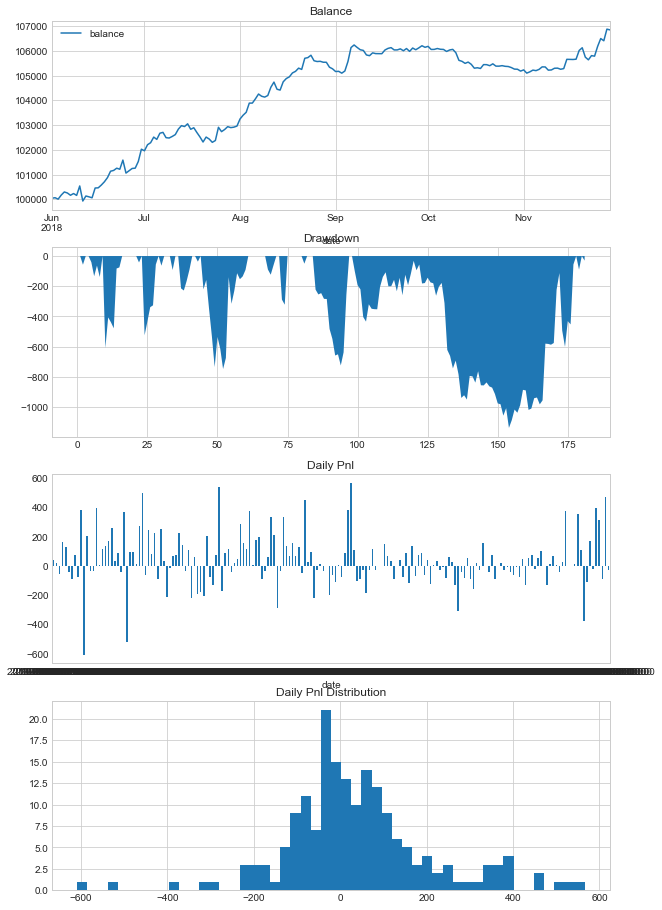

In [108]:
# 显示逐日回测结果
engine.showDailyResult()

2018-12-24 20:34:40.059496	计算回测结果
2018-12-24 20:34:40.116823	------------------------------
2018-12-24 20:34:40.117059	第一笔交易：	2018-06-02 08:00:00
2018-12-24 20:34:40.117189	最后一笔交易：	2018-11-29 11:58:00
2018-12-24 20:34:40.117286	总交易次数：	341
2018-12-24 20:34:40.117374	总盈亏：	6,843.0
2018-12-24 20:34:40.117478	最大回撤: 	-1,112.18
2018-12-24 20:34:40.117563	平均每笔盈利：	20.07
2018-12-24 20:34:40.117639	平均每笔滑点：	0.0
2018-12-24 20:34:40.117709	平均每笔佣金：	6.64
2018-12-24 20:34:40.117776	胜率		46.04%
2018-12-24 20:34:40.117841	盈利交易平均值	113.34
2018-12-24 20:34:40.117903	亏损交易平均值	-59.52
2018-12-24 20:34:40.117958	盈亏比：	1.9


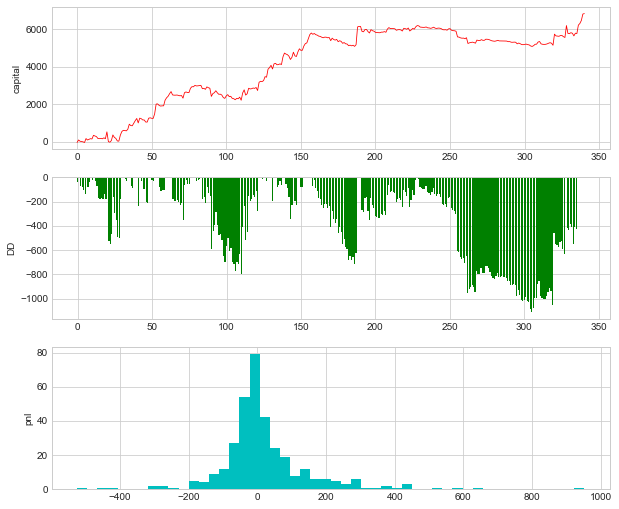

In [109]:
# 显示逐笔回测结果
engine.showBacktestingResult()

In [110]:
df = engine.calculateDailyResult()
df1, result = engine.calculateDailyStatistics(df)

2018-12-24 20:34:41.518108	计算按日统计结果


In [111]:
print(pd.Series(result)) # 显示绩效指标

annualizedReturn                9.02648
dailyCommission                  12.428
dailyNetPnl                     37.6103
dailyReturn                   0.0376103
dailySlippage                0.00748352
dailyTradeCount                 3.74176
dailyTurnover                     24856
endBalance                       106845
endDate             2018-11-29 00:00:00
lossDays                             81
maxDdPercent                   -1.07095
maxDrawdown                    -1137.73
profitDays                          101
returnStd                      0.171377
sharpeRatio                     3.39985
startDate           2018-06-01 00:00:00
totalCommission                  2261.9
totalDays                           182
totalNetPnl                     6845.08
totalReturn                     6.84508
totalSlippage                     1.362
totalTradeCount                     681
totalTurnover               4.52379e+06
dtype: object
